# Histogram of the Dimuon Mass Spectrum

This computes a "Hello World" of particle physics analysys and is intended as a technology demonstrator.  
The input is a series of candidate muon events and the output of the job is a histogram of the dimuon mass spectrum where several peaks can be identified corresponding to well-know particles and resonances.  

Implementation: 
  - this is implemented with PySpark 3.3-SNAPSHOT, showcasing the newly introduced mapInPandas, with Python libraries: awkward array and vector.
  - a second implementation using only Spark DataFrame functions (UDF) is also provided for reference

References: the computation is based on https://root.cern.ch/doc/master/df102__NanoAODDimuonAnalysis_8C.html and CERN open data from the CMS collaboraiton linked there. For reference, another and different version of this computation using Spark for scaling is at https://swan-gallery.web.cern.ch/notebooks/apache_spark1/NanoAODDimuonAnalysis-PyRDF-Spark.html

Luca Canali in collaboration with Jim Pivarski
January 2022

## Dataset preparation
This steps takes the CERN openadata dataset and prepares it.  
The preparation is a conversion from the ROOT data format (a data format used in High Energy Physics) to Apache Parquet.  
This is done using Laurelin, an open source library. Laurelin at the time of this writing could only work with Spark 2.x  

```
# Use laurelin to convert root to parquet format
# laurelin 1.1.1 does not work with Spark 3.x, we will use Spark 2.4
# Note Spark 2.4.8 does not work with Python 3.8, use earlier Python versions for this part

# I have use spark-shell to run the conversion, it can be done with pyspark too.

bin/spark-shell --master local[*] --packages edu.vanderbilt.accre:laurelin:1.1.1 --driver-memory 16g

// The input is a file in ROOT format, download it from CERN opedata:
// https://eospublic.cern.ch//eos/opendata/cms/derived-data/AOD2NanoAODOutreachTool/Run2012BC_DoubleMuParked_Muons.root

val df=spark.read.format("root").option("tree", "Events").load("/home/luca/DoubleMuParked/Run2012BC_DoubleMuParked_Muons.root")

// compact to 1 file and write
df.coalesce(1).write.mode("overwrite").parquet("/home/luca/DoubleMuParked/Run2012BC_DoubleMuParked_Muons.parquet")

```

## Dimuon mass spectrum calculation with Spark UDF mapInArrow

In [1]:
import findspark
findspark.init("/home/luca/Spark/spark-3.3.0-SNAPSHOT-bin-spark_21220128")

# custom Python if needed
#import os
#os.environ['PYSPARK_PYTHON']="...."

from pyspark.sql import SparkSession
spark = SparkSession.builder \
        .appName("dimuon mass")  \
        .master("local[4]") \
        .config("spark.driver.memory", "2g") \
        .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/01/28 19:33:20 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/01/28 19:33:20 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [2]:
# Read data with the muon candidate events

path = "/home/luca/DoubleMuParked/"

df_muons = spark.read.parquet(path + "Run2012BC_DoubleMuParked_Muons.parquet")

df_muons.printSchema()

print(f"Number of events: {df_muons.count()}")

root
 |-- nMuon: long (nullable = true)
 |-- Muon_pt: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- Muon_eta: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- Muon_phi: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- Muon_mass: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- Muon_charge: array (nullable = true)
 |    |-- element: integer (containsNull = true)

Number of events: 61540413


In [3]:
# Apply the filters to select:
#    events with 2 muons
#    the 2 muons have different charge

df_muons = df_muons.filter("nMuon==2").filter("Muon_charge[0] != Muon_charge[1]")

# add the column Dimuon_mass to the DataFrame
# it will be used as output column, to work around the limitation that 
# mapInArrow needs to have the same input and output schema.
df_muons = df_muons.selectExpr("Muon_pt", "Muon_eta","Muon_phi", "Muon_mass", "float(0.0) as Dimuon_mass")

print(f"Number of events after filter selection: {df_muons.count()}")

Number of events after filter selection: 24067843


In [4]:
df_muons.show(5, False)

+----------------------+-------------------------+------------------------+------------------------+-----------+
|Muon_pt               |Muon_eta                 |Muon_phi                |Muon_mass               |Dimuon_mass|
+----------------------+-------------------------+------------------------+------------------------+-----------+
|[10.53849, 16.327097] |[-0.42778006, 0.34922507]|[-0.2747921, 2.5397813] |[0.10565837, 0.10565837]|0.0        |
|[57.6067, 53.04508]   |[-0.5320893, -1.0041686] |[-0.07179804, 3.0895152]|[0.10565837, 0.10565837]|0.0        |
|[11.319675, 23.906353]|[-0.77165854, -0.700997] |[-2.2452729, -2.1809616]|[0.10565837, 0.10565837]|0.0        |
|[10.193569, 14.204061]|[0.44180685, 0.70211726] |[0.67785203, -2.034401] |[0.10565837, 0.10565837]|0.0        |
|[11.470704, 3.4690065]|[2.341742, 2.3523731]    |[3.1309705, 3.0211737]  |[0.10565837, 0.10565837]|0.0        |
+----------------------+-------------------------+------------------------+---------------------

In [5]:
import awkward as ak
import vector

# This is where the dimuon mass is computed
# the candidate muon events and summed as 4-vectors in the Pt, eta, phi, m space
# and the invarian mass is computed
# we use awkward arrray and vector libraries, serializing directly with arrow
def UDF_dimuonmass(iterator):
    vector.register_awkward()
    for batch in iterator:
        chunk = ak.from_arrow(batch)
        muons = ak.zip({"pt": chunk.Muon_pt, "eta": chunk.Muon_eta, "phi": chunk.Muon_phi, "mass": chunk.Muon_mass}, with_name="Momentum4D")
        mu0 = muons[:, 0]
        mu1 = muons[:, 1]
        dimuon_mass = (mu0 + mu1).mass
        out = ak.zip({"Muon_pt": chunk.Muon_pt, "Muon_eta": chunk.Muon_eta, "Muon_phi": chunk.Muon_phi, "Muon_mass": chunk.Muon_mass, "Dimuon_mass": dimuon_mass }, depth_limit=1)
        # out = ak.zip({"Muon_pt": None, "Muon_eta": None, "Muon_phi": None, "Muon_mass": None, "Dimoun_mass": dimuon_mass }, depth_limit=1)
        yield from ak.to_arrow_table(out).to_batches()

In [6]:
# apply the UDF with arrow to compute the dimuon mass spectrum

df_with_dimuonmass = df_muons.mapInArrow(UDF_dimuonmass, df_muons.schema)

In [7]:
# small sample of the computation
df_with_dimuonmass.show(5, False)


+----------------------+-------------------------+------------------------+------------------------+-----------+
|Muon_pt               |Muon_eta                 |Muon_phi                |Muon_mass               |Dimuon_mass|
+----------------------+-------------------------+------------------------+------------------------+-----------+
|[10.53849, 16.327097] |[-0.42778006, 0.34922507]|[-0.2747921, 2.5397813] |[0.10565837, 0.10565837]|27.915491  |
|[57.6067, 53.04508]   |[-0.5320893, -1.0041686] |[-0.07179804, 3.0895152]|[0.10565837, 0.10565837]|113.645424 |
|[11.319675, 23.906353]|[-0.77165854, -0.700997] |[-2.2452729, -2.1809616]|[0.10565837, 0.10565837]|1.5878798  |
|[10.193569, 14.204061]|[0.44180685, 0.70211726] |[0.67785203, -2.034401] |[0.10565837, 0.10565837]|23.723238  |
|[11.470704, 3.4690065]|[2.341742, 2.3523731]    |[3.1309705, 3.0211737]  |[0.10565837, 0.10565837]|0.75032544 |
+----------------------+-------------------------+------------------------+---------------------

In [8]:
# compute the histogram

min_val = 0.40
max_val = 200
num_bins = 30000
step = (max_val - min_val) / num_bins

histogram_data = ( 
    df_with_dimuonmass
        .where(f"Dimuon_mass between {min_val} and {max_val}")
        .selectExpr(f"width_bucket(Dimuon_mass, {min_val}, {max_val}, {num_bins}) as bucket") 
        .groupBy("bucket")
        .count()
        .orderBy("bucket")
    )

# convert bucket number to the corresponding dimoun mass value
histogram_data = histogram_data.selectExpr(f"round({min_val} + (bucket - 1) * {step},2) as value", "count as N_events")


In [9]:
%%time

# The action toPandas() here triggers the computation.
# Histogram data is fetched into the driver.

histogram_data_pandas=histogram_data.toPandas()

CPU times: user 169 ms, sys: 8.21 ms, total: 177 ms
Wall time: 1min 26s


In [10]:
histogram_data_pandas.count()

value       29772
N_events    29772
dtype: int64

## Histogram plotting
Histogram of the dimuon mass spectrum where several peaks can be identified corresponding to well-know particles and resonances

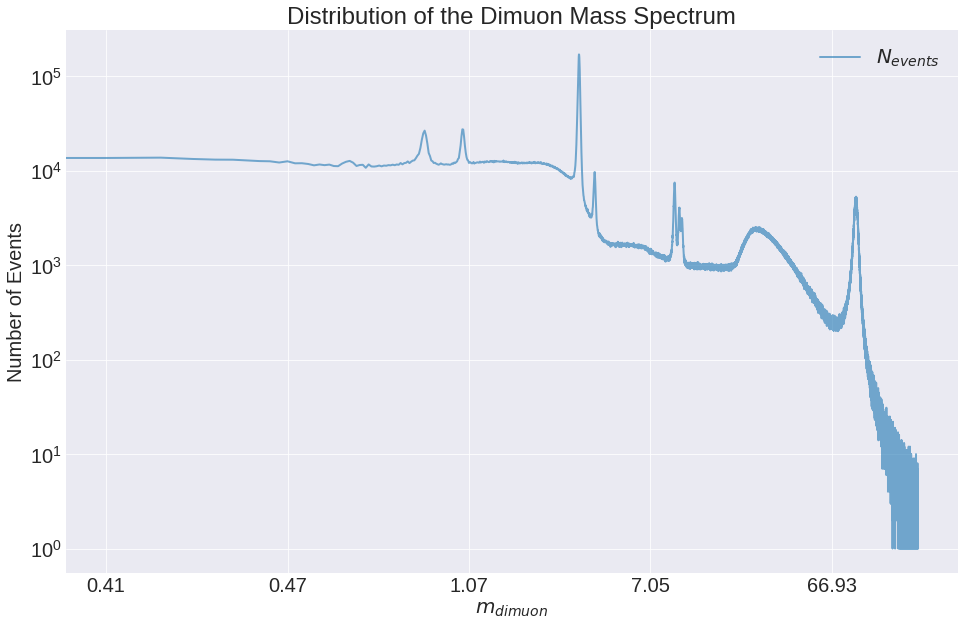

In [11]:
import matplotlib.pyplot as plt 
plt.style.use('seaborn-darkgrid')
plt.rcParams.update({'font.size': 20, 'figure.figsize': [16,10]})

# histogram_data_pandas is a pandas dataframe containing the bins value and counts foreach bin
# the plot is in log-log axis to better show the peaks
ax = histogram_data_pandas.plot(x='value', y='N_events', kind='line', label='$N_{events}$', loglog=True,
                                alpha=0.6, linewidth=2.0)

ax.set_xlabel('$m_{dimuon}$')
ax.set_ylabel('Number of Events')
ax.set_title("Distribution of the Dimuon Mass Spectrum")

plt.show()

------

## Computation of the dimuon spectrum using only Spark DataFrame functions (no UDF)
The following performs the same dimuon mass spectrum calculation using only Spark DataFrame functions. 
The normal wisedom is that UDFs are slower than using Spark functions, but in this case the situation is reversed.


In [12]:
# Read data with the muon candidate events
# and apply the filters
# this is the same code as what was used earlier in Dimuon mass spectrum calculation with Spark UDF mapInArrow 

path = "/home/luca/DoubleMuParked/"

df_muons = spark.read.parquet(path + "Run2012BC_DoubleMuParked_Muons.parquet")
df_muons = df_muons.filter("nMuon==2").filter("Muon_charge[0] != Muon_charge[1]")
df_muons = df_muons.selectExpr("Muon_pt", "Muon_eta","Muon_phi", "Muon_mass", "float(0.0) as Dimuon_mass")

In [13]:
# sum the 4-vectors for the 2 mouns
# convert the 4-vector from pt,eta,phi,m to to px,py,pz,E
# as this will simplify the computation of the mass in the next step
df_dimuon = df_muons.selectExpr(
    "Muon_pt[0] * cos(Muon_phi[0]) + Muon_pt[1] * cos(Muon_phi[1]) px",
    "Muon_pt[0] * sin(Muon_phi[0]) + Muon_pt[1] * sin(Muon_phi[1]) py",
    "Muon_pt[0] * sinh(Muon_eta[0]) + Muon_pt[1] * sinh(Muon_eta[1]) pz",
    "Muon_pt[0] * cosh(Muon_eta[0]) + Muon_pt[1] * cosh(Muon_eta[1]) E",
)

# compute the mass from the px,py,pz,E components of the 4-vector
df_with_dimuonmass = df_dimuon.selectExpr("sqrt(E*E - (px*px + py*py + pz*pz) ) as Dimuon_mass")

In [14]:
# compute the histogram
# this is the same code as what was used earlier in Dimuon mass spectrum calculation with Spark UDF mapInArrow 

min_val = 0.40
max_val = 200
num_bins = 30000
step = (max_val - min_val) / num_bins

histogram_data = ( 
    df_with_dimuonmass
        .where(f"Dimuon_mass between {min_val} and {max_val}")
        .selectExpr(f"width_bucket(Dimuon_mass, {min_val}, {max_val}, {num_bins}) as bucket") 
        .groupBy("bucket")
        .count()
        .orderBy("bucket")
    )

# convert bucket number to the corresponding dimoun mass value
histogram_data = histogram_data.selectExpr(f"round({min_val} + (bucket - 1) * {step},2) as value", "count as N_events")

In [15]:
%%time

# The action toPandas() here triggers the computation.
# Histogram data is fetched into the driver.

histogram_data_pandas=histogram_data.toPandas()

CPU times: user 226 ms, sys: 10.2 ms, total: 237 ms
Wall time: 2min 2s


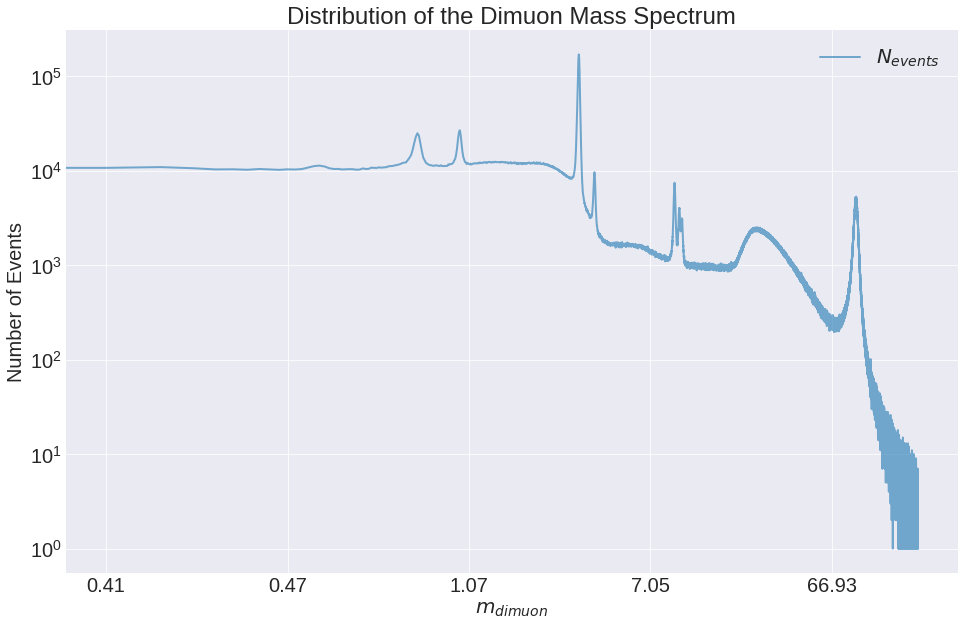

In [16]:
import matplotlib.pyplot as plt 
plt.style.use('seaborn-darkgrid')
plt.rcParams.update({'font.size': 20, 'figure.figsize': [16,10]})

# histogram_data_pandas is a pandas dataframe containing the bins value and counts foreach bin
# the plot is in log-log axis to better show the peaks
ax = histogram_data_pandas.plot(x='value', y='N_events', kind='line', label='$N_{events}$', loglog=True,
                                alpha=0.6, linewidth=2.0)

ax.set_xlabel('$m_{dimuon}$')
ax.set_ylabel('Number of Events')
ax.set_title("Distribution of the Dimuon Mass Spectrum")

plt.show()